In [1]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd
import scipy
import matplotlib
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


# Theoretic part (20 pts, 5 pts each)

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation). 
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

##### Answer: C
Expain: Option C is correct because the presence of local peaks in the autocorrelation plot of a daily time-series at lags of 7, 14, 21, 28, etc. indicates a strong correlation between the observations separated by a lag of 7 days. This suggests that the time-series has a periodic pattern with a period of 7 days, which is likely to correspond to weekly seasonality.  The autocorrelation plot only shows the correlation between observations at different lags, but it does not provide information about the level or frequency of the time-series, the number of periods per day, or the appropriate order of an AR model. Therefore, options A, B, D, and E are not necessarily correct based on the given information.

### Question 2 (Stationarity).

Which of the following time-series models are stationary:

A. Linear trend

B. AR(1) model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Answer: B,C,D,E. White noise as well as AR, MA, ARMA models are known to be stationary. Any model with a trend is not as the trend assumes changing mean of the time-series changing over time. A random walk is not stationary as its variance accumulates over time. ARIMA with at least one differencing, including ARIMA(1,1,1) is not stationary.

##### Answer: B,C,E
Expain: White noise as well as AR, MA, ARMA models are known to be stationary. Any model with a trend is not as the trend assumes changing mean of the time-series changing over time. A random walk is not stationary as its variance accumulates over time. ARIMA with at least one differencing, including ARIMA(1,1,1) is not stationary.

### Question 3 (PCA). 
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

##### Answer:  B,D,E
A is false. The leading principal components may be sufficient to capture most of the variance in the data, while in others, more components may be required. Therefore, it is important to determine the optimal number of principal components that capture the most variance in the data while avoiding overfitting.\
B is correct.Standardizing the features before performing PCA ensures that each feature has the same scale. Standardization also ensures that the principal components are uncorrelated, making them less susceptible to the problems of multicollinearity.\
C is false.  While PCA can help to reduce the dimensionality of the feature space and prevent overfitting to some extent, it is still possible to overfit a model that uses principal components of the features.In fact, overfitting can occur if too many principal components are used or if the model is too complex. It is important to determine the optimal number of principal components that capture most of the variance in the data without overfitting the model.\
D is correct through the explanation for C. \
E is correct.  PCA does not change the underlying relationships between the original features and the output variable but creates a new set of features that capture the most variance in the data. The new features are linear combinations of the original features, and their interpretation is less intuitive than that of the original features. This can make it difficult to interpret the PCA regression model, especially if the original features have a clear interpretation.


### Question 4 (MapReduce). 

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of you CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



###### Answer:  B,E
A is false. Mapreduce is not a module enabling parallel computing and pool is the module.\
B is True.  Because MapReduce breaks down a large dataset into smaller chunks and processes them in parallel, which is more suitable for parallel computing compared to traditional approaches like loops or list comprehensions.\
C is false. Statement C is false because the performance of MapReduce code depends on various factors such as data size, number of nodes, and processing power. In some cases, traditional approaches may be more efficient than MapReduce.\
D is False. Statement D is not entirely true because MapReduce code can only run efficiently on multiple cores or machines if the data is distributed properly and the system is configured correctly.\
E is True. Statement E is true because Multiprocessing and PySpark are alternatives to MapReduce that can also be used for parallel processing of large datasets.

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading. 

## 1. Data downloading (5pts)
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [2]:
dataDir = 'taxidata'
if os.path.exists(dataDir):
    pass
else:
    os.mkdir(dataDir)
Years = [2017,2018]
Months = range(1,13)
VehicleTypes = ['yellow']

def getUrl(cabtype,year,month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'
    
    month = str(month).zfill(2)
    fileName = '%s_tripdata_%s-%s.parquet'%(cabtype,year,month)
        
    return baseUrl + fileName, fileName        

In [3]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)
            
            print("Downloading: "+str(fileName))
            
            if fileName in os.listdir(dataDir):
                print("file exists")
                continue
            
            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later!")
                    pass


Downloading: yellow_tripdata_2017-01.parquet
file exists
Downloading: yellow_tripdata_2017-02.parquet
file exists
Downloading: yellow_tripdata_2017-03.parquet
file exists
Downloading: yellow_tripdata_2017-04.parquet
file exists
Downloading: yellow_tripdata_2017-05.parquet
file exists
Downloading: yellow_tripdata_2017-06.parquet
file exists
Downloading: yellow_tripdata_2017-07.parquet
file exists
Downloading: yellow_tripdata_2017-08.parquet
file exists
Downloading: yellow_tripdata_2017-09.parquet
file exists
Downloading: yellow_tripdata_2017-10.parquet
file exists
Downloading: yellow_tripdata_2017-11.parquet
file exists
Downloading: yellow_tripdata_2017-12.parquet
file exists
Downloading: yellow_tripdata_2018-01.parquet
file exists
Downloading: yellow_tripdata_2018-02.parquet
file exists
Downloading: yellow_tripdata_2018-03.parquet
file exists
Downloading: yellow_tripdata_2018-04.parquet
file exists
Downloading: yellow_tripdata_2018-05.parquet
file exists
Downloading: yellow_tripdata_20

In [4]:
#another method
url_list=[]
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            c=getUrl(cabtype,year,month)
            url_list.append(c)

def download_url(url, folder_name, file_name):
    os.makedirs(folder_name, exist_ok=True)
    
    file_path = os.path.join(folder_name, file_name)
    urllib.request.urlretrieve(url, file_path)
folder_name = "taxidata_mothod"
for i in url_list:
    download_url(i[0],folder_name,i[1])


## 2. Data Preprocessing (10 pts, 7 for dask, 3 for sanity check)
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc. 

Hint: 
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_csv("*.csv") to read all csv file in a folder 
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [5]:
#apply argument usecols to select desired columns.
#Try read_csv("*.csv") to read all csv file in a folder
read_column=['VendorID','tpep_pickup_datetime','PULocationID','DOLocationID','passenger_count']
df = dd.read_parquet('/Users/ryanng/Desktop/midterm-Zihao-Wu999-main 2/taxidata/*.parquet', dtype={'trip_distance': float,
                        'total_amount': float, 'tolls_amount':float, 'RatecodeID': float, 'VendorID': float, 
                                                     'passenger_count': float, 'payment_type':float, 
                                                     'PULocationID':int, 'DOLocationID':int},columns=read_column)
df.head()

,VendorID,tpep_pickup_datetime,PULocationID,DOLocationID,passenger_count
0,1,2017-01-01 00:32:05,140,236,1
1,1,2017-01-01 00:43:25,237,140,2
2,1,2017-01-01 00:49:10,140,237,2
3,1,2017-01-01 00:36:42,41,42,1
4,1,2017-01-01 00:07:41,48,263,1


In [6]:
#JFK taxi zone id is 132.
df = df[(df["PULocationID"] == 132)]
df.head()

,VendorID,tpep_pickup_datetime,PULocationID,DOLocationID,passenger_count
45,2,2017-01-01 00:33:10,132,92,5
48,2,2017-01-01 00:36:06,132,141,1
128,2,2017-01-01 00:24:14,132,132,6
185,2,2017-01-01 00:30:38,132,181,1
197,2,2017-01-01 00:28:38,132,39,1


In [7]:
#aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. 
df["hour"] = dd.to_datetime(df["tpep_pickup_datetime"]).dt.hour
df["date"]=dd.to_datetime(df["tpep_pickup_datetime"]).dt.date
agg_df = df.groupby(['date', 'hour', 'DOLocationID'])['passenger_count'].sum().reset_index()

In [8]:
agg_df=agg_df.compute()

In [9]:
# pivot table to reshape data
pivot_df = agg_df.pivot_table(index=['date', 'hour'], columns='DOLocationID', values='passenger_count').fillna(0)

# reset column index
pivot_df.columns.name = None
pivot_df = pivot_df.reset_index()
pivot_df

,date,hour,1,2,3,4,5,6,7,8,...,256,257,258,259,260,261,262,263,264,265
0,2002-12-31,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2003-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2003-01-01,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008-12-31,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008-12-31,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17538,2018-12-31,23,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,...,0.0,11.0,0.0,0.0,1.0,1.0,8.0,13.0,0.0,25.0
17539,2019-01-16,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17540,2019-02-03,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17541,2019-05-07,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2018-12-31")
pivot_df = pivot_df[(pivot_df["date"] >= start_date) & (pivot_df["date"] <= end_date)]
pivot_df

,date,hour,1,2,3,4,5,6,7,8,...,256,257,258,259,260,261,262,263,264,265
21,2017-01-01,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0
22,2017-01-01,1,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0
23,2017-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
24,2017-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
25,2017-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17534,2018-12-31,19,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.0,1.0,5.0,0.0,2.0,5.0,19.0,15.0,0.0,23.0
17535,2018-12-31,20,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,6.0,4.0,0.0,0.0,8.0,1.0,9.0,13.0,0.0,16.0
17536,2018-12-31,21,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,...,4.0,5.0,5.0,0.0,1.0,1.0,16.0,13.0,4.0,23.0
17537,2018-12-31,22,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,...,1.0,11.0,0.0,1.0,0.0,5.0,16.0,9.0,0.0,25.0


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [11]:
# Step 1: Create a new dataframe with all possible combinations of dates and hours
date_range = pd.date_range(start="2017-01-01", end="2019-01-01", freq="H")
date_hour_df = pd.DataFrame(columns=['date','hour'])
date_hour_df['date']=date_range.date
date_hour_df['hour']=date_range.hour

start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2018-12-31")
date_hour_df = date_hour_df[(date_hour_df["date"] >= start_date) & (date_hour_df["date"] <= end_date)]

# Step 2: Merge with original dataframe using a left join
merged_df = pd.merge(date_hour_df,pivot_df, on=["date", "hour"], how="left")

# Step 3: Fill any missing values with 0
merged_df = merged_df.fillna(0)

# Step 4: Sort by date and hour
merged_df = merged_df.sort_values(by=["date", "hour"]).reset_index(drop=True)

# Check that the resulting dataframe has 17520 rows
print(len(merged_df))  # Output: 17520

17520


In [12]:
merged_df

,date,hour,1,2,3,4,5,6,7,8,...,256,257,258,259,260,261,262,263,264,265
0,2017-01-01,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0
1,2017-01-01,1,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0
2,2017-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2017-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2017-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2018-12-31,19,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.0,1.0,5.0,0.0,2.0,5.0,19.0,15.0,0.0,23.0
17516,2018-12-31,20,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,6.0,4.0,0.0,0.0,8.0,1.0,9.0,13.0,0.0,16.0
17517,2018-12-31,21,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,...,4.0,5.0,5.0,0.0,1.0,1.0,16.0,13.0,4.0,23.0
17518,2018-12-31,22,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,...,1.0,11.0,0.0,1.0,0.0,5.0,16.0,9.0,0.0,25.0


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records. (3pts)

In [13]:
day_data=merged_df
day_data=day_data.groupby("date").sum()
day_data = day_data.drop('hour', axis=1)
day_data

,1,2,3,4,5,6,7,8,9,10,...,256,257,258,259,260,261,262,263,264,265
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,27.0,128.0,...,127.0,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0
2017-01-02,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,11.0,116.0,...,135.0,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0
2017-01-03,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,17.0,161.0,...,123.0,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0
2017-01-04,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,3.0,147.0,...,125.0,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0
2017-01-05,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,8.0,182.0,...,115.0,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,8.0,0.0,2.0,33.0,0.0,0.0,116.0,1.0,5.0,136.0,...,109.0,21.0,14.0,5.0,45.0,103.0,78.0,93.0,44.0,192.0
2018-12-28,5.0,0.0,4.0,58.0,0.0,1.0,67.0,0.0,4.0,163.0,...,89.0,37.0,28.0,6.0,16.0,84.0,88.0,135.0,29.0,211.0
2018-12-29,8.0,0.0,3.0,21.0,0.0,1.0,99.0,0.0,11.0,112.0,...,109.0,33.0,27.0,6.0,26.0,62.0,100.0,114.0,32.0,254.0


In [14]:
data_t3=day_data
# sum all columns and create new column
data_t3['total'] =data_t3.sum(axis=1)

# drop original columns
data_t3 = data_t3[['total']]
data_t3

,total
date,
2017-01-01,14710.0
2017-01-02,16723.0
2017-01-03,16072.0
2017-01-04,14549.0
2017-01-05,12239.0
...,...
2018-12-27,12256.0
2018-12-28,12117.0
2018-12-29,11913.0


### 3.2 Period detection and report the strongest period length on the 2017 data. (3pts)
Hint: using periodogram or acf plot.

In [15]:
#get the data of 2017
start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2017-12-31")
data_2017 = data_t3[(data_t3.index >= start_date) & (data_t3.index <= end_date)]
data_2017

,total
date,
2017-01-01,14710.0
2017-01-02,16723.0
2017-01-03,16072.0
2017-01-04,14549.0
2017-01-05,12239.0
...,...
2017-12-27,12521.0
2017-12-28,11880.0
2017-12-29,12062.0


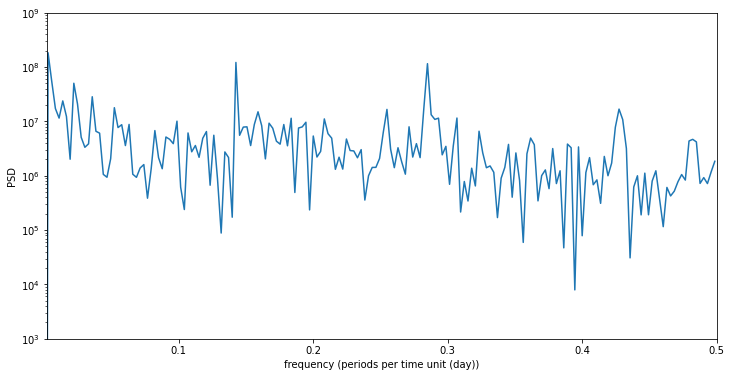

Strongest period length = 7.019230769230769


In [16]:
f, PSD = scipy.signal.periodogram(data_2017.total)
plt.figure(figsize = (12,6))
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (day))')
plt.ylabel('PSD')
plt.xlim(0.002,0.5) #show frequencies within 1/4..1/200, periods of 2-365 days
plt.ylim(1e3,1e9) #show strength up to 1e-6 of the max

#filter outputs - periods shorter than 2 years (approx 100 weeks) 
PSD = PSD[f>0.01]
f = f[f>0.01] 
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

<Figure size 576x576 with 0 Axes>

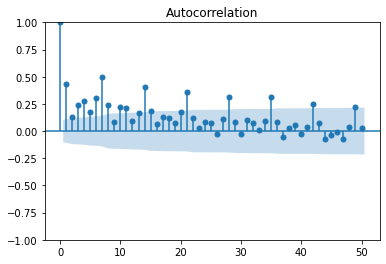

In [17]:
# acf plot
plt.figure(figsize = (8,8))
plot_acf(data_2017['total'], lags = 50)
plt.show()
#plot autocorrelations for lags up to 50 days
#we see spikes around 7days (1 week), 14 days (2 weeks), ... highlighting an week period

<Figure size 576x576 with 0 Axes>

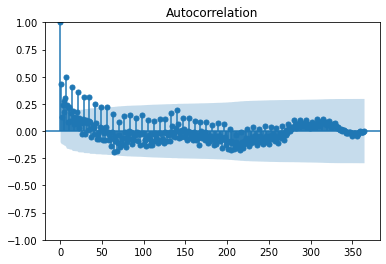

In [18]:
# acf plot
plt.figure(figsize = (8,8))
plot_acf(data_2017['total'], lags = 364)
plt.show()
#plot autocorrelations for lags up to 365 days
#we see spikes around 7days (1 week), 14 days (2 weeks), ... highlighting an week period

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, . (3 pts, 1 pts if freq is wrong)

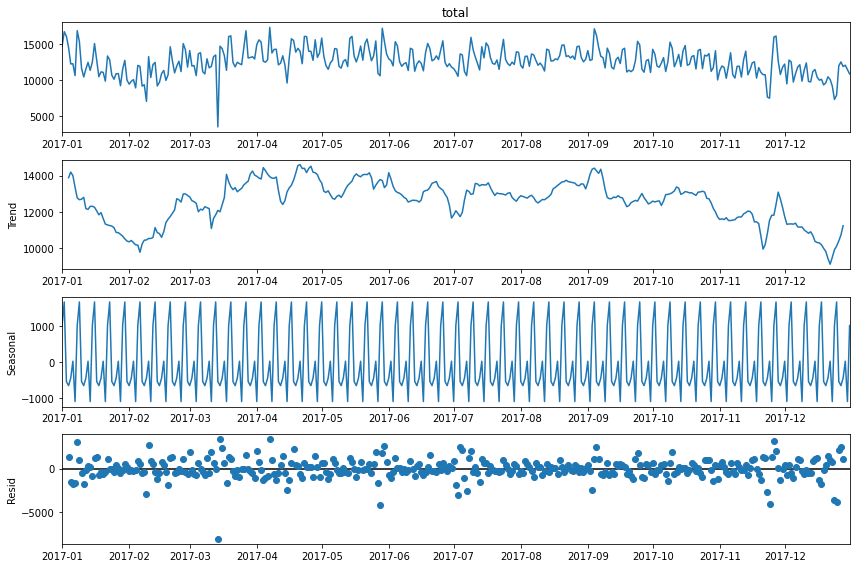

In [19]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
decomposition = sm.tsa.seasonal_decompose(data_2017.total,model='additive',period=7)
decomposition.plot()
plt.show()

<BarContainer object of 7 artists>

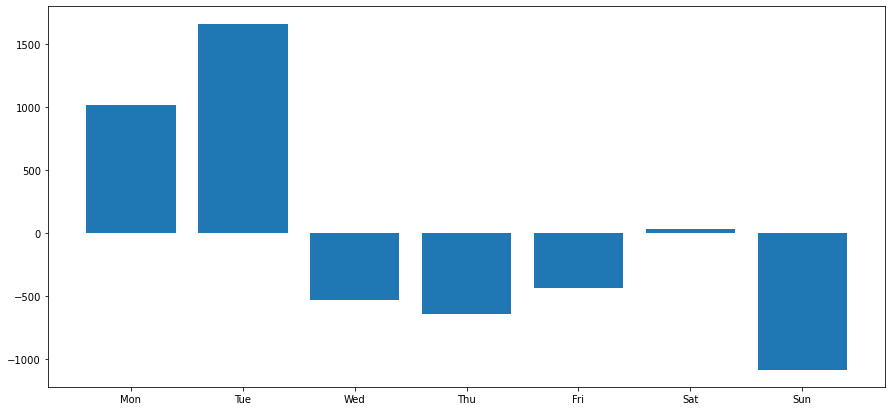

In [20]:
fig = plt.figure(figsize=(15, 7))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        decomposition.seasonal[:7])

In [21]:
dailyData=data_2017.reset_index()
dailyData['DOW'] = pd.to_datetime(dailyData.date).dt.dayofweek #monday = 0, sunday = 6
# train the model over the first 730 days (2 years)
X = pd.concat([pd.DataFrame(range(dailyData.shape[0]),columns=['day']),pd.get_dummies(dailyData['DOW'],drop_first=False)],axis=1)


#X = sm.add_constant(X) #we do not need an intercept as we have an individual constant for each day of the week (drop_first = False)
#alternatively we can add a constant but then exclude a dummy for Monday using drop_first = True - will do so below
lm=sm.OLS(dailyData.total,X).fit()
print (lm.summary())

#dailyData['DOW'] = dailyData.index.dayofweek #monday = 0, sunday = 6

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     17.76
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           3.17e-20
Time:                        08:32:57   Log-Likelihood:                -3208.8
No. Observations:                 365   AIC:                             6434.
Df Residuals:                     357   BIC:                             6465.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day           -2.1546      0.799     -2.695      0.0

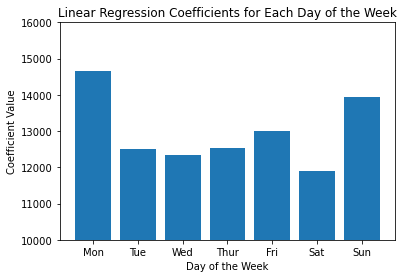

In [22]:
DOW_L = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
PARAMS=lm.params[1:8].tolist()
fig = plt.figure(figsize=(6, 4))
plt.bar(DOW_L, PARAMS)
plt.xlabel('Day of the Week')
plt.ylabel('Coefficient Value')
plt.ylim([10000,16000])
plt.title('Linear Regression Coefficients for Each Day of the Week')
plt.show()

In [23]:
dailyData['passenger_pred']=lm.predict(X)

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05. (3pts)

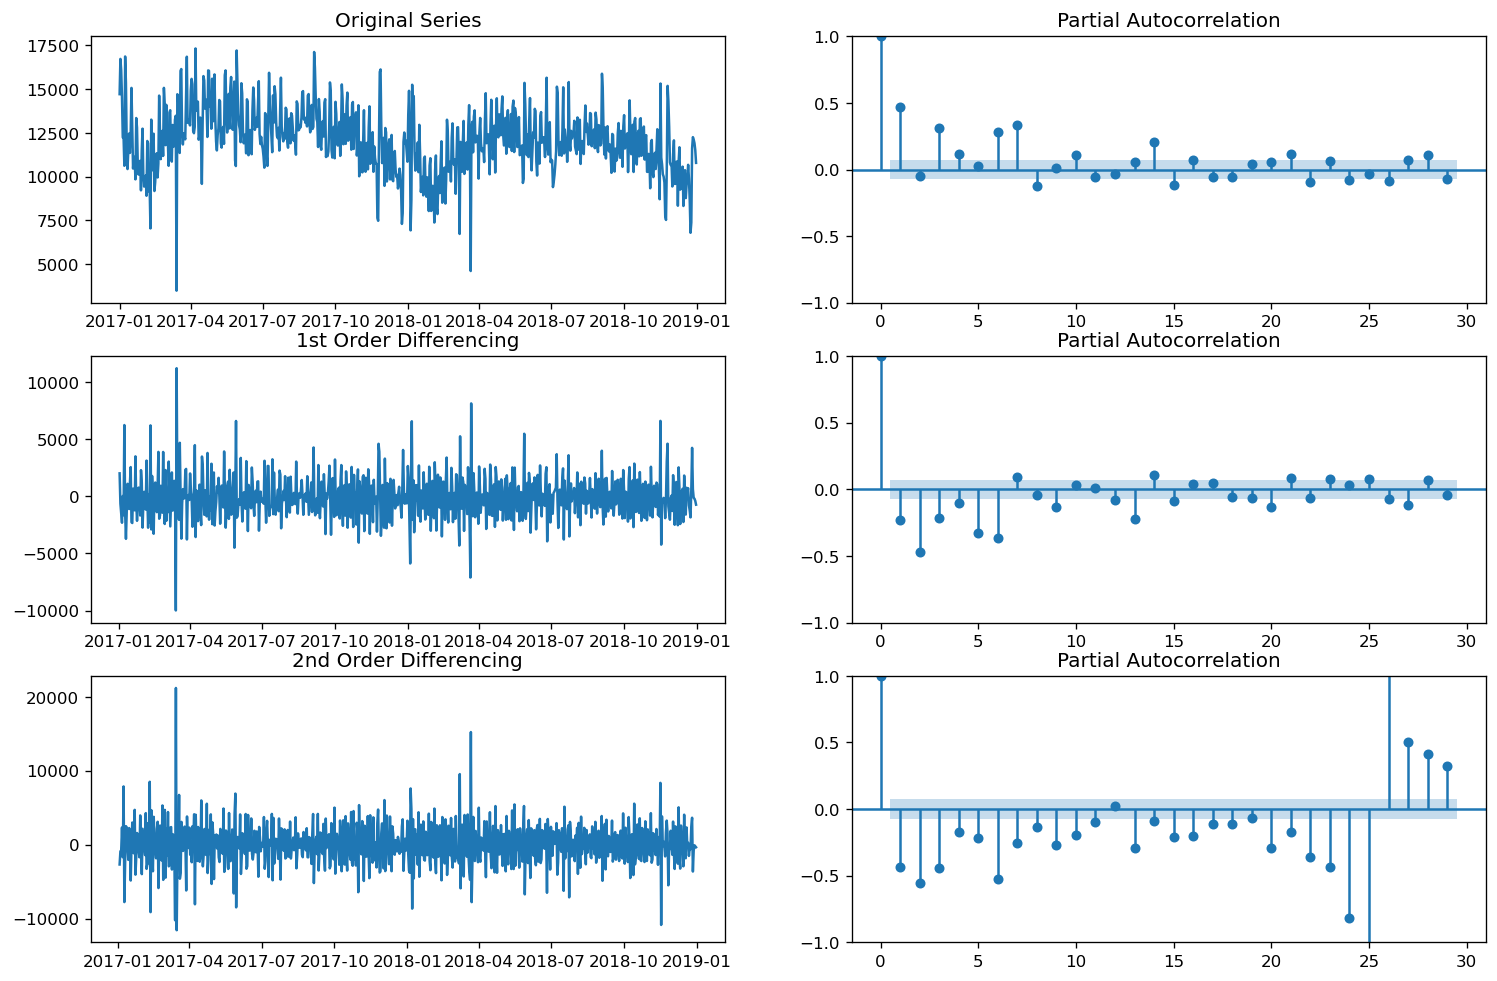

In [24]:
data_t4=data_t3
#use pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(data_t4.total); axes[0, 0].set_title('Original Series')
plot_pacf(data_t4.total, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(data_t4.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(data_t4.total.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(data_t4.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(data_t4.total.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

In [25]:
data_t4=data_t3

# raw
series=data_t4['total']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=data_t4['total'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=data_t4['total'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: -2.153742
  p-value: 0.223460

1st order differencing:
  ADF Statistic: -8.181998
  p-value: 0.000000

2nd order differencing:
  ADF Statistic: -12.229794
  p-value: 0.000000


As we can see from the result, after first difference , the p-value is smaller than 0.05. So d=1.

### 4.2 Find out proper AR and MA terms in an ARIMA model using pacf and acf plots. (4 pts, 2 for each plot)
Hint: positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. In general, differencing reduces positive autocorrelation and may even cause a switch from positive to negative autocorrelation. 

Identifying the numbers of AR and MA terms:
1. if the pacf plot shows a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

2. if the acf plot displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

3. It is generally advisable to stick to models in which at least one of p and q is no larger than 1, i.e., do not try to fit a model such as ARIMA(2,1,2).

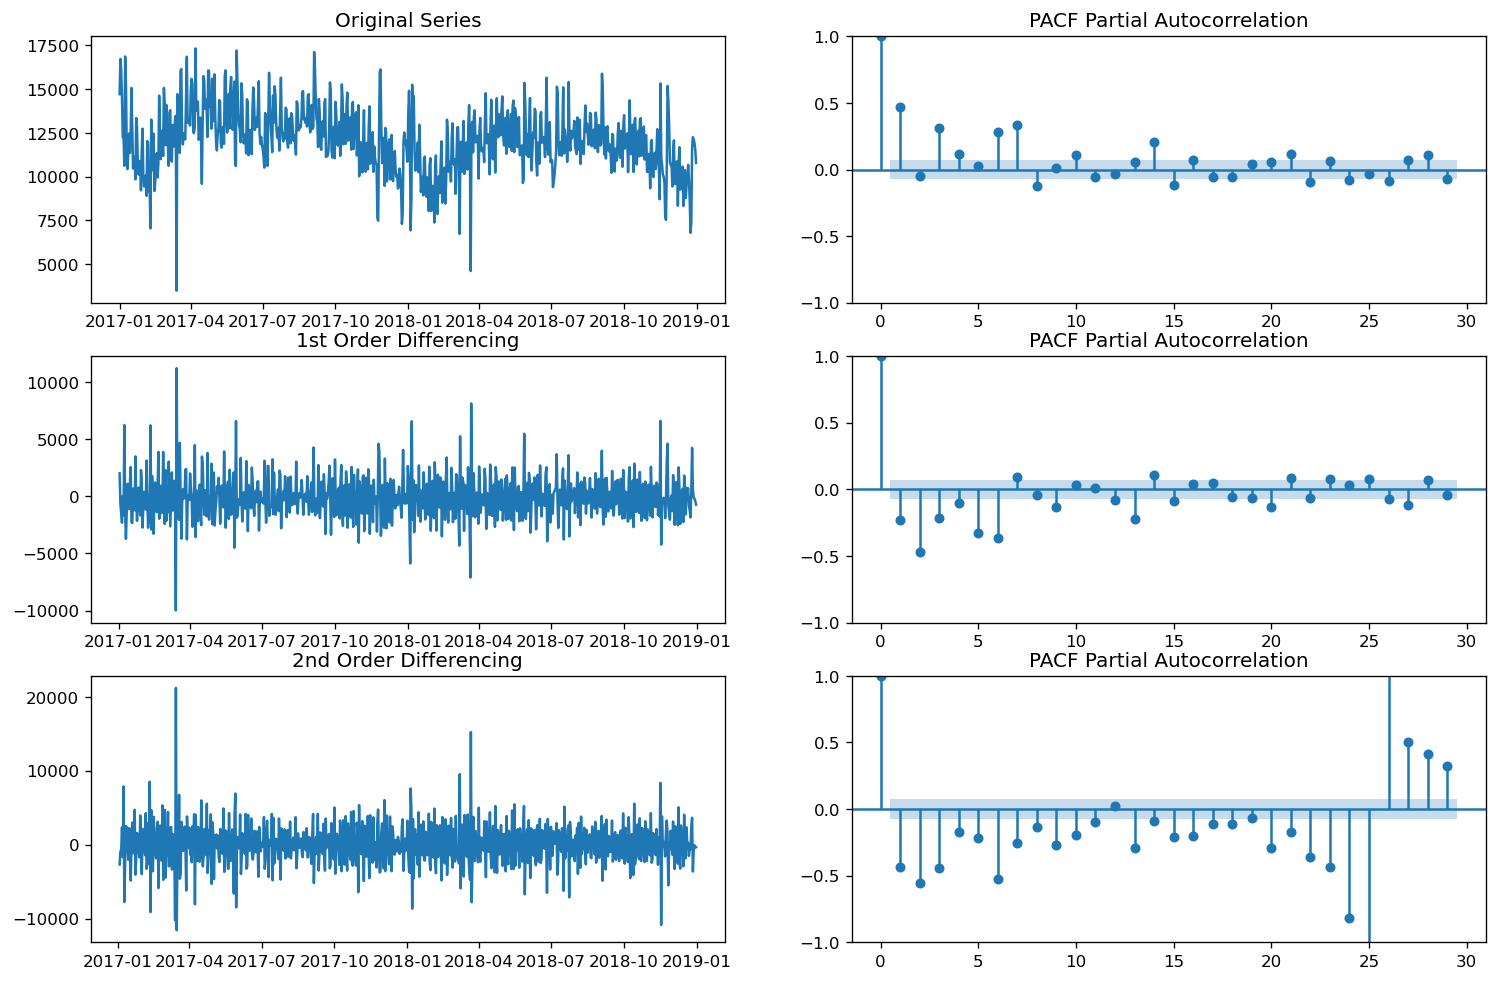

In [26]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(data_t4.total); axes[0, 0].set_title('Original Series')
plot_pacf(data_t4.total, ax=axes[0, 1])
axes[0, 1].set_title('PACF Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(data_t4.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(data_t4.total.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('PACF Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(data_t4.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(data_t4.total.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('PACF Partial Autocorrelation')

plt.show()

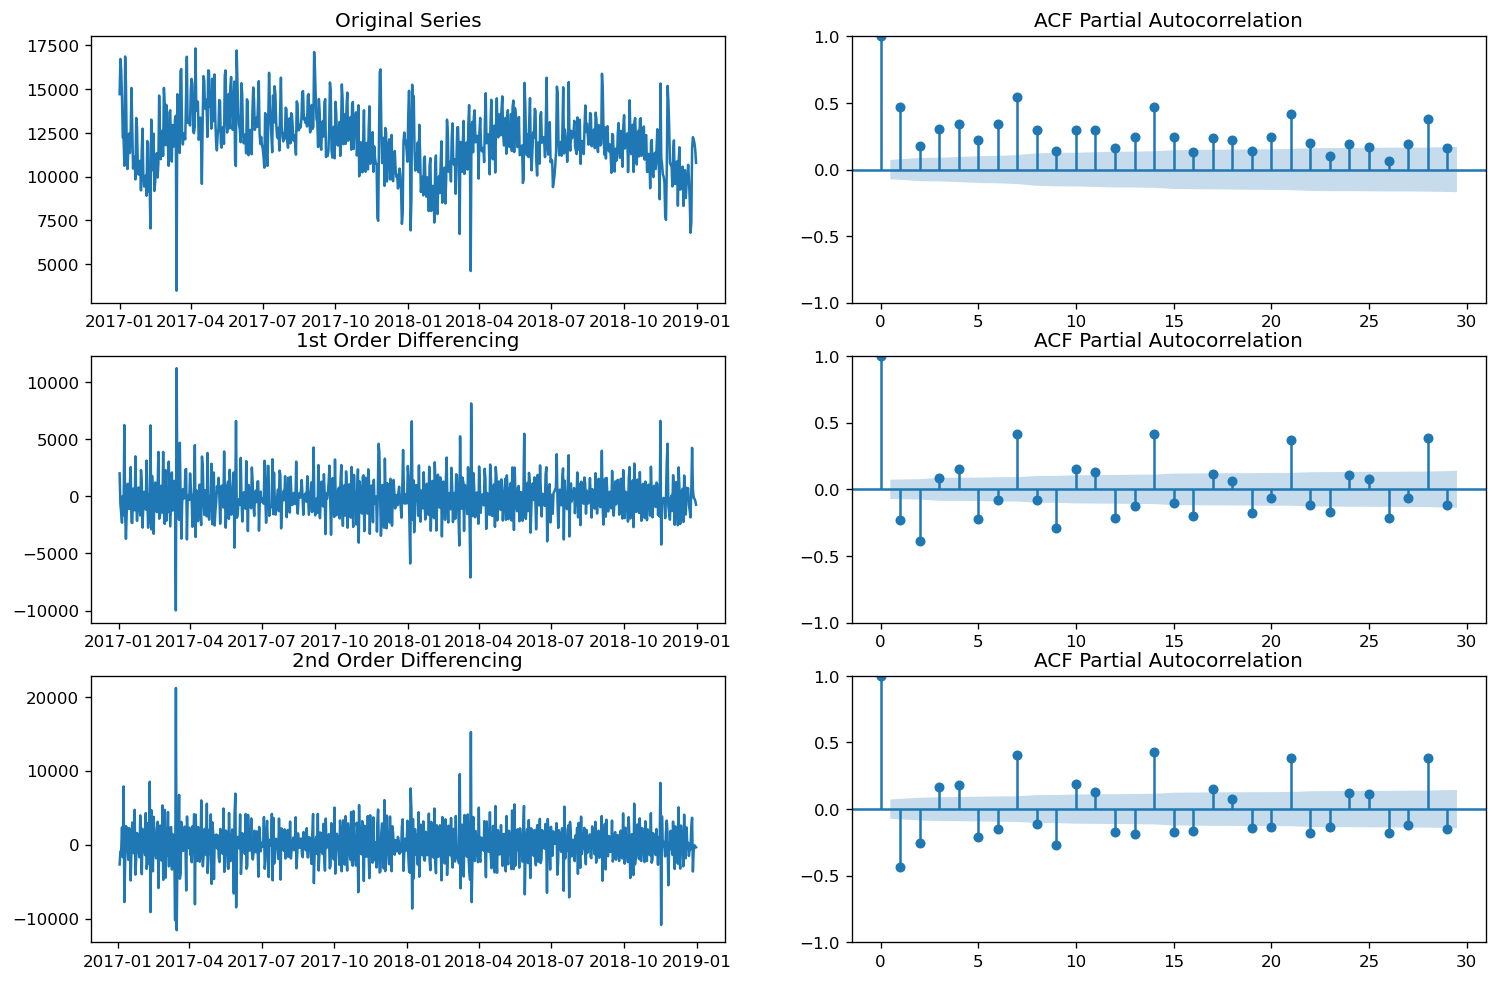

In [27]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(data_t4.total); axes[0, 0].set_title('Original Series')
plot_acf(data_t4.total, ax=axes[0, 1])
axes[0, 1].set_title('ACF Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(data_t4.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_t4.total.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('ACF Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(data_t4.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_t4.total.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('ACF Partial Autocorrelation')

plt.show()

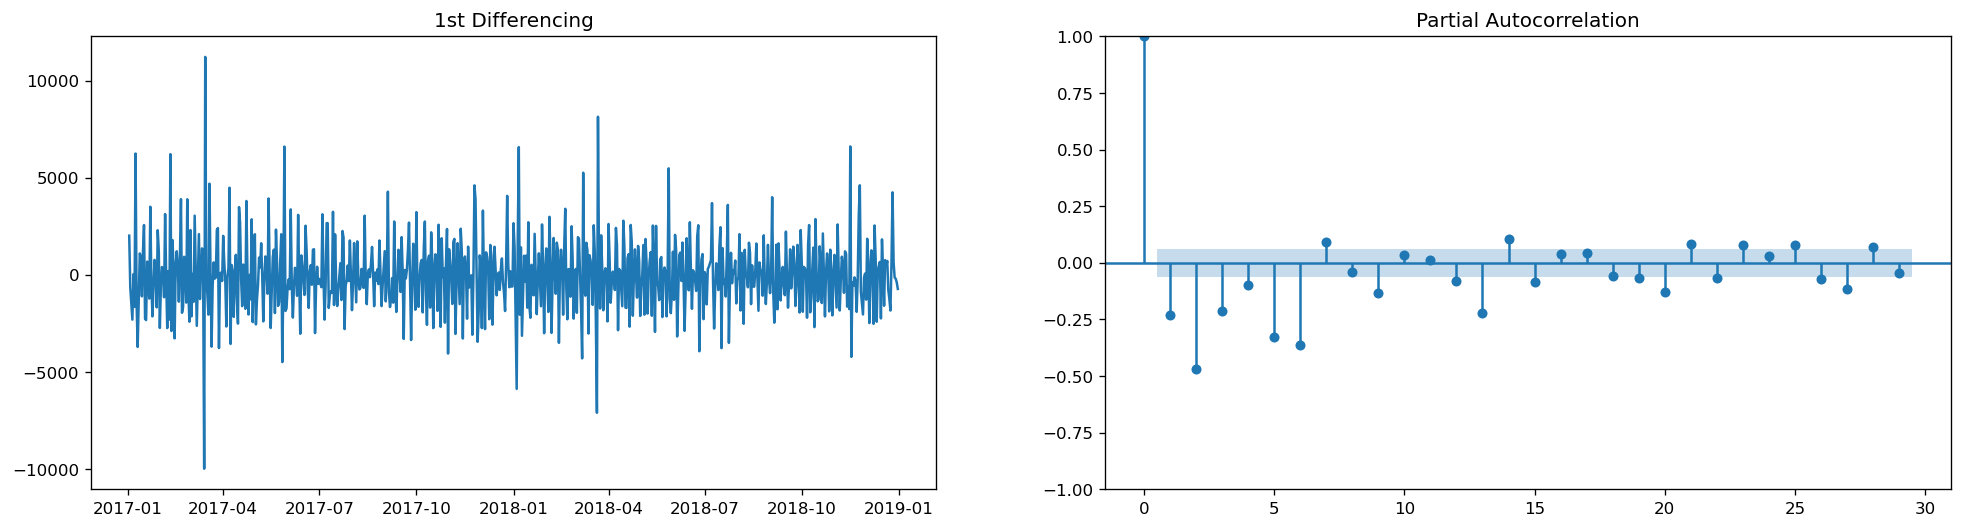

In [28]:
#find the ar terms
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(data_t4.total.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(data_t4.total.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations
plt.show()

#thus Q=2

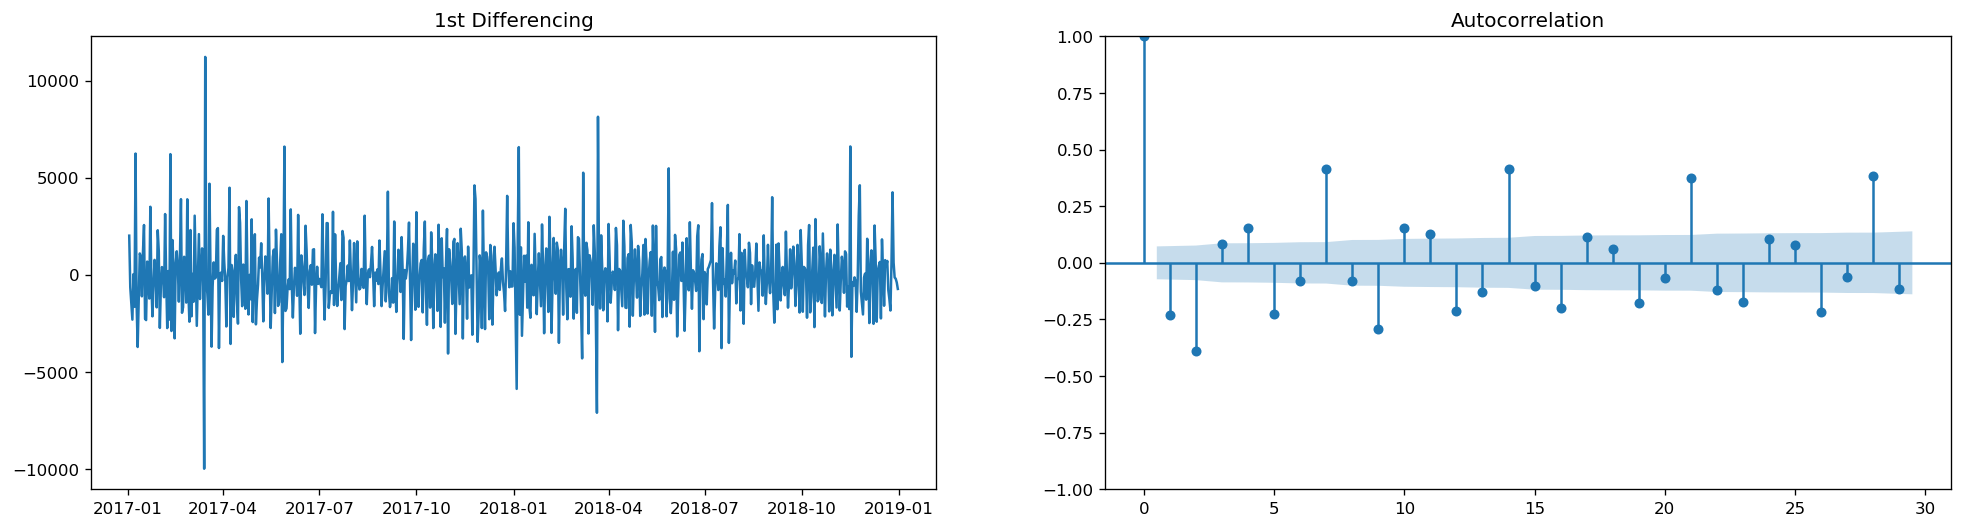

In [29]:
#find the ma terms
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(data_t4.total.diff()); axes[0].set_title('1st Differencing')
plot_acf(data_t4.total.diff().dropna(), ax=axes[1])
plt.show()

#thus P=2 \
It is generally advisable to stick to models in which at least one of p and q is no larger than 1, i.e., do not try to fit a model such as ARIMA(2,1,2).\
So we will run  1,1,2 or 2,1,1\
Frome the acf, the spike is more freequently than pacf. we will try 1,1,2


### 4.3 build an ARIMA model using terms from 4.2, training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors. (8 pts, 3 for correct terms, 3 for training and summary, 2pts for the plot)

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                  700
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6106.458
Date:                Mon, 27 Mar 2023   AIC                          12220.916
Time:                        08:32:59   BIC                          12239.114
Sample:                    01-01-2017   HQIC                         12227.951
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2535      0.078     -3.257      0.001      -0.406      -0.101
ma.L1         -0.3313      0.071     -4.655      0.000      -0.471      -0.192
ma.L2         -0.5524      0.062     -8.899      0.0

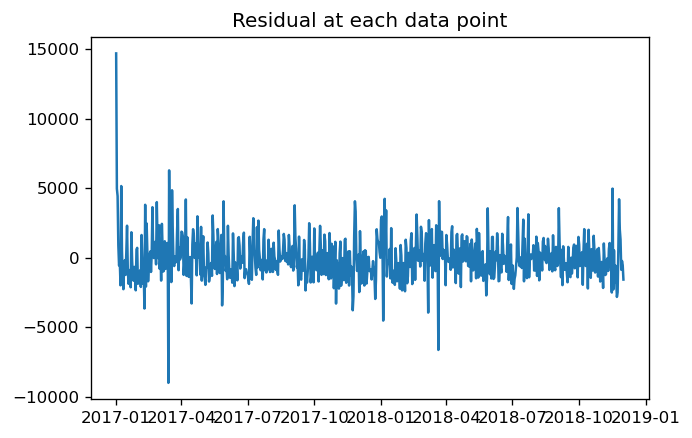

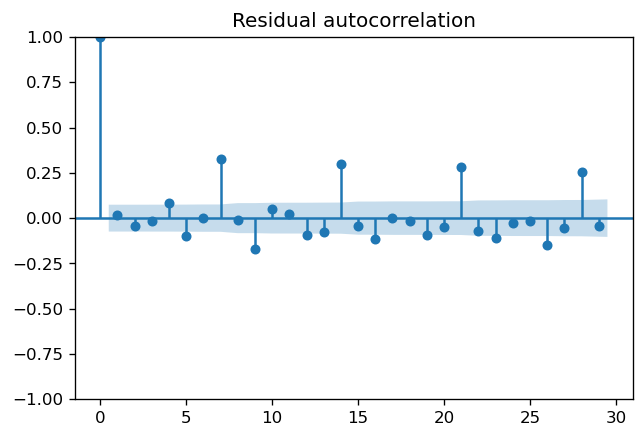

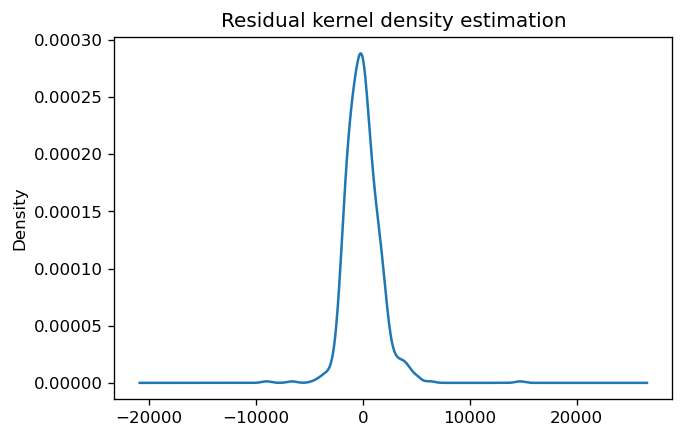

                  0
count    700.000000
mean      10.322079
std     1609.787181
min    -8987.449790
25%     -960.101738
50%     -116.085746
75%      827.450369
max    14710.000000
p value is  6.566201536289861e-57
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
       lb_stat     lb_pvalue
1     0.278531  5.976655e-01
2     1.672700  4.332892e-01
3     1.814951  6.116867e-01
4     6.420305  1.698816e-01
5    13.061364  2.281046e-02
6    13.065189  4.201234e-02
7    89.864422  1.319151e-16
8    89.916297  4.835995e-16
9   110.781034  1.019504e-19
10  112.558330  1.625014e-19


In [30]:
#WE choose q=1,p=2,d=1

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=2
D=1
Q=1

# fit model
N=700  
series = data_t4['total']#.values

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))


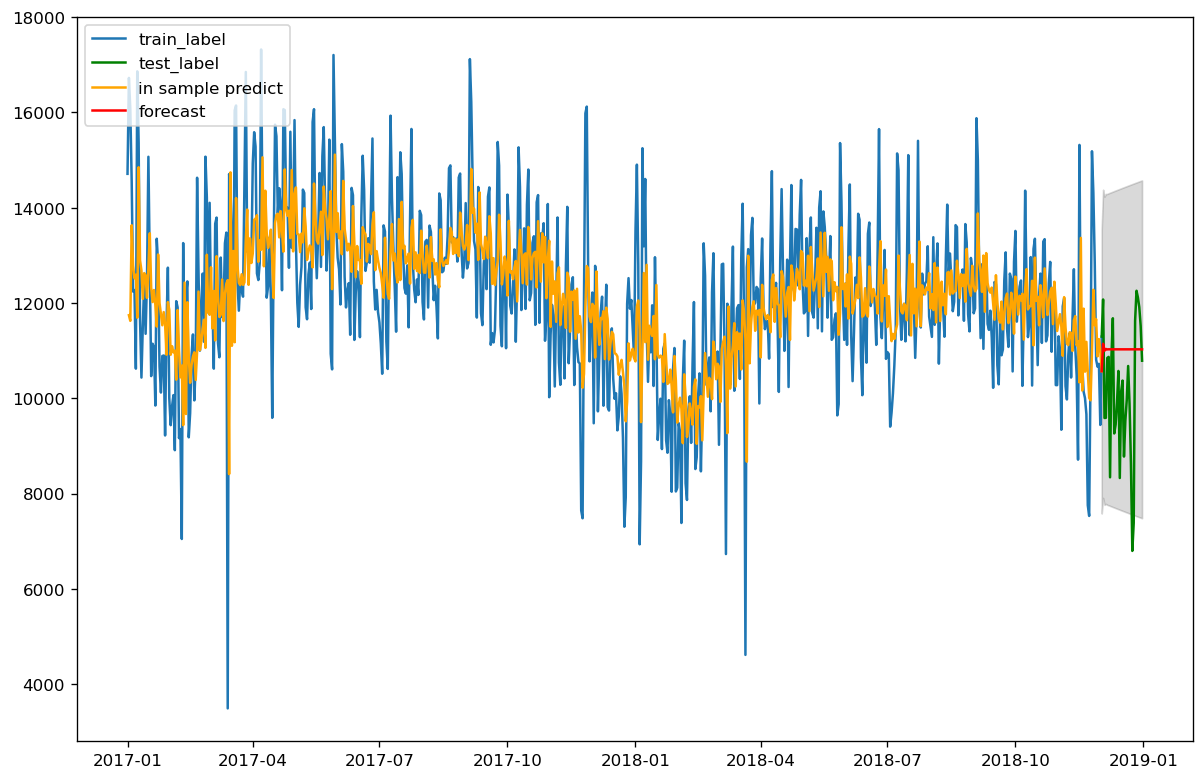

In [31]:
df_T4=data_t4

# Forecast
fcast = model_fit.forecast(steps=len(df_T4) - N)
fc = model_fit.get_forecast(steps=len(df_T4) - N).summary_frame()
index1=fc.index
fc_series = pd.Series(fc['mean'], index=index1)
lower_series = pd.Series(fc['mean_ci_lower'], index=index1)
upper_series = pd.Series(fc['mean_ci_upper'], index=index1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_T4.index[:N+1], series[:N+1], label='train_label')
ax.plot(df_T4.index[N:len(df_T4)], series[N:len(df_T4)], color='green', label='test_label')
ax.plot(df_T4.iloc[1:N+1].index, model_fit.predict(start=1, end=N, dynamic=False, typ='levels'),
        color='orange', label='in sample predict')
ax.plot(fc_series, label='forecast', color='red')
ax.fill_between(df_T4.iloc[N:len(df_T4)].index, lower_series, upper_series, color='k', alpha=.15)
ax.legend(loc='upper left')


# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct 

In [32]:
data_t5=day_data
data_t5=data_t5.iloc[:,:263]
data_t5

,1,2,3,4,5,6,7,8,9,10,...,256,257,258,259,260,261,262,263,264,265
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,27.0,128.0,...,127.0,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0
2017-01-02,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,11.0,116.0,...,135.0,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0
2017-01-03,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,17.0,161.0,...,123.0,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0
2017-01-04,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,3.0,147.0,...,125.0,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0
2017-01-05,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,8.0,182.0,...,115.0,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,8.0,0.0,2.0,33.0,0.0,0.0,116.0,1.0,5.0,136.0,...,109.0,21.0,14.0,5.0,45.0,103.0,78.0,93.0,44.0,192.0
2018-12-28,5.0,0.0,4.0,58.0,0.0,1.0,67.0,0.0,4.0,163.0,...,89.0,37.0,28.0,6.0,16.0,84.0,88.0,135.0,29.0,211.0
2018-12-29,8.0,0.0,3.0,21.0,0.0,1.0,99.0,0.0,11.0,112.0,...,109.0,33.0,27.0,6.0,26.0,62.0,100.0,114.0,32.0,254.0


In [33]:
day_data

,1,2,3,4,5,6,7,8,9,10,...,257,258,259,260,261,262,263,264,265,total
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,27.0,128.0,...,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0,14710.0
2017-01-02,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,11.0,116.0,...,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0,16723.0
2017-01-03,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,17.0,161.0,...,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0,16072.0
2017-01-04,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,3.0,147.0,...,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0,14549.0
2017-01-05,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,8.0,182.0,...,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0,12239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,8.0,0.0,2.0,33.0,0.0,0.0,116.0,1.0,5.0,136.0,...,21.0,14.0,5.0,45.0,103.0,78.0,93.0,44.0,192.0,12256.0
2018-12-28,5.0,0.0,4.0,58.0,0.0,1.0,67.0,0.0,4.0,163.0,...,37.0,28.0,6.0,16.0,84.0,88.0,135.0,29.0,211.0,12117.0
2018-12-29,8.0,0.0,3.0,21.0,0.0,1.0,99.0,0.0,11.0,112.0,...,33.0,27.0,6.0,26.0,62.0,100.0,114.0,32.0,254.0,11913.0


### 5.1. standardization. (3 pts)
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [34]:
#get the data of 2017
start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2017-12-31")
data_t5_2017 = data_t5[(data_t5.index >= start_date) & (data_t5.index <= end_date)]
data_t5_2017
#get the data of 2017
start_date = pd.to_datetime("2018-01-01")
end_date = pd.to_datetime("2018-12-31")
data_t5_2018 = data_t5[(data_t5.index >= start_date) & (data_t5.index <= end_date)]
data_t5_2018

# standardize the data
sc = StandardScaler()
data_t5_2017 = sc.fit_transform(data_t5_2017)

# standardize the data
sc = StandardScaler()
data_t5_2018 = sc.fit_transform(data_t5_2018)


data_t5_2017

array([[ 0.29513597,  2.09537592, -1.34348862, ...,  2.94616367,
         0.5696591 ,  0.55195171],
       [ 0.03045629, -0.20135745, -0.35133213, ...,  4.94142019,
         1.98857377,  0.33910187],
       [ 1.75087423, -0.20135745,  0.88886349, ...,  3.22674662,
         2.64345746,  1.44896176],
       ...,
       [ 1.08917502, -0.20135745, -0.84741038, ...,  0.54562066,
         0.02392269, -1.68297162],
       [-0.63124291, -0.20135745,  1.13690261, ...,  0.60797243,
        -1.8315811 , -1.22686482],
       [ 0.03045629, -0.20135745,  1.63298086, ...,  1.9485354 ,
         0.67880638, -0.23863341]])

In [35]:
data_t5_2018

array([[ 0.85262666, -0.14185547, -0.53537997, ...,  2.31142685,
        -0.63079164, -0.01935339],
       [-0.34709859, -0.14185547,  2.51063678, ...,  2.70320927,
        -0.5118051 ,  1.38099622],
       [ 1.21254424, -0.14185547, -1.00399794, ...,  2.14818417,
        -0.27383203, -0.54837435],
       ...,
       [-0.70701617, -0.14185547, -0.53537997, ...,  0.12397499,
         0.55907372, -0.36166107],
       [-0.22712607, -0.14185547, -0.76968895, ...,  1.527862  ,
         0.20211412, -0.45501771],
       [-0.46707112, -0.14185547, -0.76968895, ...,  1.4299164 ,
         0.91603333, -0.03491283]])

### 5.2. PCA

#### 5.2.1 train PCA on 2017 data. Let's arbitrarily set PCA components as 5, and gamma is None, try kernel ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. Select the transformer which has the lowest mean squared error in data reconstruction (inverse transform). (5 pts)

In [36]:
kernel_list=['linear', 'poly', 'rbf', 'sigmoid']
performance=[]
for i in kernel_list:
    X=data_t5_2017
    kpca = KernelPCA(kernel=i, n_components=5,fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(X)
    X_reconstructed = kpca.inverse_transform(kpca.fit_transform(X))
    mse = mean_squared_error(X, X_reconstructed)
    score=(i,mse)
    performance.append(score)

In [37]:
performance

[('linear', 0.704386426899276),
 ('poly', 0.6827189865698111),
 ('rbf', 0.7655881012642223),
 ('sigmoid', 0.7833848292573721)]

As we can see from the result, we get the poly mse is the smallest

#### 5.2.2 Apply the selected transformer from 4.2.1 to the standardized 2018 dataset and report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data.(5pts)

In [38]:
X_2017=data_t5_2017
X_2018=data_t5_2018
kpca = KernelPCA(kernel='poly', n_components=5,fit_inverse_transform=True)

data_t5_2017_transformed = kpca.fit_transform(X_2017)

# Apply the fitted PCA to the standardized 2018 data
data_t5_2018_transformed = kpca.transform(X_2018)

# Reconstruct the standardized 2018 data using the inverse transform method
data_t5_2018_reconstructed = kpca.inverse_transform(data_t5_2018_transformed)

# Compute the mean squared error between the standardized 2018 data and reconstructed data
mse = mean_squared_error(data_t5_2018, data_t5_2018_reconstructed)
print("Mean Squared Error: {:.4f}".format(mse))


Mean Squared Error: 0.7766


### 5.3 Add lag (5pts)
add 12 lags of each component from 4.2.2 (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [39]:
# Convert transformed data to a DataFrame
data_pca_2018 = pd.DataFrame(data_t5_2018_transformed, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'])

# Add 12 lags of each component
for i in range(5):
    component_name = 'Component {}'.format(i+1)
    for lag in range(1, 13):
        data_pca_2018['{}_lag{}'.format(component_name, lag)] = data_pca_2018[component_name].shift(lag)

# Drop rows with missing values
data_pca_2018_lagged = data_pca_2018.dropna()

# Extract lagged features and target variables
X_lagged = data_pca_2018_lagged.drop(['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'], axis=1)
y = data_pca_2018_lagged[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]

In [40]:
data_pca_2018_lagged

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 1_lag1,Component 1_lag2,Component 1_lag3,Component 1_lag4,Component 1_lag5,...,Component 5_lag3,Component 5_lag4,Component 5_lag5,Component 5_lag6,Component 5_lag7,Component 5_lag8,Component 5_lag9,Component 5_lag10,Component 5_lag11,Component 5_lag12
12,0.010911,-0.282930,0.047505,0.005007,0.166324,0.343314,0.017316,0.375748,-0.146638,-1.188700,...,0.129403,0.158316,0.021861,0.431586,0.204475,0.142613,0.074668,0.420669,0.392757,0.393005
13,0.408894,-0.025657,0.177999,0.186447,0.482795,0.010911,0.343314,0.017316,0.375748,-0.146638,...,0.068684,0.129403,0.158316,0.021861,0.431586,0.204475,0.142613,0.074668,0.420669,0.392757
14,-0.635220,0.350808,0.554744,-0.445630,0.834953,0.408894,0.010911,0.343314,0.017316,0.375748,...,0.141636,0.068684,0.129403,0.158316,0.021861,0.431586,0.204475,0.142613,0.074668,0.420669
15,-0.021146,-0.171903,-0.024592,0.193926,0.175318,-0.635220,0.408894,0.010911,0.343314,0.017316,...,0.166324,0.141636,0.068684,0.129403,0.158316,0.021861,0.431586,0.204475,0.142613,0.074668
16,0.894067,0.116066,0.032119,0.309940,0.023266,-0.021146,-0.635220,0.408894,0.010911,0.343314,...,0.482795,0.166324,0.141636,0.068684,0.129403,0.158316,0.021861,0.431586,0.204475,0.142613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-0.384270,-0.051730,0.093035,0.029480,0.209320,-0.050253,1.955254,2.301965,1.272605,0.625380,...,-0.098469,-0.097884,0.013453,-0.121908,-0.037373,-0.056529,-0.120043,-0.083772,0.004514,-0.062483
361,-0.364396,-0.074743,-0.004772,0.131862,0.229051,-0.384270,-0.050253,1.955254,2.301965,1.272605,...,-0.161940,-0.098469,-0.097884,0.013453,-0.121908,-0.037373,-0.056529,-0.120043,-0.083772,0.004514
362,-0.282480,-0.053058,0.250646,0.066384,0.336094,-0.364396,-0.384270,-0.050253,1.955254,2.301965,...,0.101196,-0.161940,-0.098469,-0.097884,0.013453,-0.121908,-0.037373,-0.056529,-0.120043,-0.083772
363,-0.404399,0.131855,0.212679,0.432724,0.512545,-0.282480,-0.364396,-0.384270,-0.050253,1.955254,...,0.209320,0.101196,-0.161940,-0.098469,-0.097884,0.013453,-0.121908,-0.037373,-0.056529,-0.120043


## 6. RandomForest modeling (23pts)

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%. 


### Extra credit: 

Using grid_search function in sklearn instead of a for-loop when tuning parameters in a RandomForest. The train, validation, and test datasets should be split in the same way as described above. Hint: To fix train and validation in a grid search, you might need the PredefinedSplit function from sklearn.

### 6.1 train test split (3pts)
Please keep in mind that random train test split is not applicable in this case.

In [41]:
X=data_pca_2018_lagged.iloc[:,6:]
y=data_pca_2018_lagged.iloc[:,:5]

In [42]:
# Split the dataset into training and testing sets (80/20 split)
train_idx = int(0.8 * len(X))
X_train, y_train = X[:train_idx], y[:train_idx]
X_test, y_test = X[train_idx:], y[train_idx:]
# Split the training set into training and validation sets (80/20 split)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [43]:
len(X_train)

282

In [44]:
#PredefinedSplit function from sklearn.
# Assign all data points to an unknown fold (-1)
n_samples = len(X_train)
fold_labels = np.full(n_samples, -1)

# Assign first 80% of data points to fold 0, which will be the training set
n_train = int(n_samples * 0.8)
fold_labels[:n_train] = 0

# Assign the remaining 20% of data points to fold 1, which will be the test set
fold_labels[n_train:] = 1

# Create a PredefinedSplit object
ps = PredefinedSplit(fold_labels)

In [45]:
fold_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 6.2 parameter tuning (10pts)
Please search the best parameter set in the following range:
min_samples_split: 2 to 10,
min_samples_leaf: 2 to 10,
and n_estimators equal to 50.


In [46]:
# Define the parameter grid for the random forest model
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50],
    'min_samples_split': [2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10],
}


# Create the random forest model
rf_model = RandomForestRegressor(random_state=42)

# Use GridSearchCV with predefined split to tune the parameters
rf_grid = GridSearchCV(rf_model, param_grid=param_grid, cv=ps, scoring='neg_mean_squared_error',n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Print the best parameters and corresponding score
print("Best parameters: ", rf_grid.best_params_)
print("Best score: ", -rf_grid.best_score_)

Best parameters:  {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best score:  0.10326410378468734


### 6.3 model performance measurement (10pts)
Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. Report the taxi zone level $R^2$ value.

In [47]:
#using rf to predict the  PCA components
rf_model = RandomForestRegressor(n_estimators=50, min_samples_split=5,min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# inverse PCA
y_pred_transformed=kpca.inverse_transform(y_pred)
y_test_transformed=kpca.inverse_transform(y_test)

# inverse standarlization
y_pred_transformed=sc.inverse_transform(y_pred_transformed)
y_test_transformed=sc.inverse_transform(y_test_transformed)


In [48]:
#Report the taxi zone level  𝑅2  value.
transformed_r2 = r2_score(y_test_transformed, y_pred_transformed)
transformed_r2

-0.19227017435223967

In [49]:
#we can get the true value of taxi zone
#get the data of test
start_date = pd.to_datetime("2018-10-22")
end_date = pd.to_datetime("2018-12-31")
y_true = data_t5[(data_t5.index >= start_date) & (data_t5.index <= end_date)]
true_r2=r2_score(y_true, y_pred_transformed)
true_r2

-0.05807212126823952